## TTITrace分析脚本-FDD
---
**环境**：
- Python 3.5+
- pandas 0.18.1
- matlibplot 2.0.0
- numpy 1.11.3+mkl

**功能**

**历史**
- 0.01: 2017/07/31

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

TTITRACE_PATH = r"D:\userdata\anliu\Desktop\NB-IOT\ttitrace"
FILENAME_DL = "ttiTrace_20180209141054_1232_dl.csv"
FILENAME_UL = "ttiTrace_20180209141054_1233_ul.csv"

def csv_prepare(file, comment="Time"):
    nrow = 0
    with open(file,"r") as f:
        for line in f:
            nrow = nrow + 1
            if line.startswith(comment): 
                return nrow-1

def load_tti_data(ttitrace_path=TTITRACE_PATH, ttitrace_name=FILENAME_DL):
    file = os.path.join(ttitrace_path, ttitrace_name)
    csv_data = pd.read_csv(file, low_memory=False, skiprows=csv_prepare(file), 
                           na_values=['-'], error_bad_lines=False, warn_bad_lines=False)
    return csv_data

### Analyze DL ttitrace

In [2]:
print('Start to analyze DL ttitrace...')
# 读取数据并整理
ttitrace_dl = load_tti_data(TTITRACE_PATH, FILENAME_DL)
ttitrace_dl = ttitrace_dl.iloc[:,:-1]
ttitrace_dl.dropna(axis=0, subset=['ETtiTraceDlParUe_cRnti','ETtiTraceDlParCell_cellId'], inplace=True)
ttitrace_dl.reset_index(inplace=True)
ttitrace_dl['Time'] = [pd.datetime.strftime(pd.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S.%fZ'), '%H:%M:%S.%f')[:-3]
                       for s in ttitrace_dl['Time']]

# 打印dataframe基本信息
ttitrace_dl.info()

# 抽取Cell ID，PRB数目
# ttitrace中每个tti对应多个UE的调度，在统计某些参数时候需要对统一时间戳的数值求和，比如单tti调度的prb数目prb_used
cell_id = ttitrace_dl['ETtiTraceDlParCell_cellId'][0]
prb_available = ttitrace_dl.groupby('Time')['ETtiTraceDlParCell_totalPrbAvail'].mean()
prb_available_mean = prb_available.mean()
prb_used = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_numberOfPrsAlloc'].sum()
prb_used_mean = prb_used.mean()
print('cell id:', int(cell_id))
print('available prb number: {:.1f}'.format(prb_available_mean))
print('prb allocated: {:.1f}'.format(prb_used_mean))

# 统计 cqi
wbcqi_cw1 = ttitrace_dl["ETtiTraceDlParUe_wbCqiCw0"].mean()
wbcqi_cw2 = ttitrace_dl["ETtiTraceDlParUe_wbCqiCw1"].mean()
print('wbcqi on cw1: {:.1f}'.format(wbcqi_cw1))
print('wbcqi on cw2: {:.1f}'.format(wbcqi_cw2))

# 统计fd（dl subframe UE per tti）
dl_fd_num = ttitrace_dl['ETtiTraceDlParCell_numUesFd'].mean()
print('dl mean FD number: {:.1f}'.format(dl_fd_num))

# 分别对单tti和总测试时间段统计dl mcs
dl_mcs_index_cw1 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_mcsIndexCw1'].mean()
dl_mcs_index_cw2 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_mcsIndexCw2'].mean()
dl_mcs_index_cw1_mean = dl_mcs_index_cw1.mean()
dl_mcs_index_cw2_mean = dl_mcs_index_cw2.mean()
print('dl mean mcs for cw1: {:.1f}'.format(dl_mcs_index_cw1_mean))
print('dl mean mcs for cw2: {:.1f}'.format(dl_mcs_index_cw2_mean))

# 分别对单tti和总测试时间段统计dl tb size
dl_tbs_cw1 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_tbsCw1'].sum()
dl_tbs_cw2 = ttitrace_dl.groupby('Time')['ETtiTraceDlParUe_tbsCw2'].sum()
dl_tbs_cw1_mean = dl_tbs_cw1.mean()
dl_tbs_cw2_mean = dl_tbs_cw2.mean()
print('dl mean tbs for cw1: {:.1f}'.format(dl_tbs_cw1_mean))
print('dl mean tbs for cw2: {:.1f}'.format(dl_tbs_cw2_mean))

# 统计dl ack ratio，dl harq状态包括ack，ack，dtx
dl_ack_cw1_group = ttitrace_dl.groupby('EHarqParDl_ackNackDtxCw1')
dl_ack_cw1 = dl_ack_cw1_group.size()['ACK']/dl_ack_cw1_group.size().sum()
print('dl harq ack ratio for cw1: {:.1f}%'.format(dl_ack_cw1*100))
# dl_ack_cw2_group = ttitrace_dl.groupby('EHarqParDl_ackNackDtxCw2')
# dl_ack_cw2 = dl_ack_cw2_group.size()['ACK']/dl_ack_cw2_group.size().sum()
# print('dl harq ack ratio for cw2: {:.1f}%'.format(dl_ack_cw2*100))

# 统计DRB数目
dl_drb_count = ttitrace_dl['ETtiTraceDlParUe_numDrb'].mean()
print('drb number is: {:.1f}'.format(dl_drb_count))

Start to analyze DL ttitrace...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60029 entries, 0 to 60028
Columns: 238 entries, index to EHarqParDl_feedbackXsfn
dtypes: float64(159), int64(42), object(37)
memory usage: 109.0+ MB
cell id: 43841
available prb number: 15.0
prb allocated: 9.9
wbcqi on cw1: 15.0
wbcqi on cw2: nan
dl mean FD number: 3.1
dl mean mcs for cw1: 18.5
dl mean mcs for cw2: nan
dl mean tbs for cw1: 589.1
dl mean tbs for cw2: 0.0
dl harq ack ratio for cw1: 100.0%
drb number is: 3.0


FD number VS Subframe number:


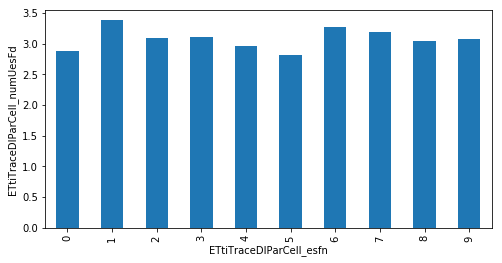

CW1/CW2 MCS Index Distribution:


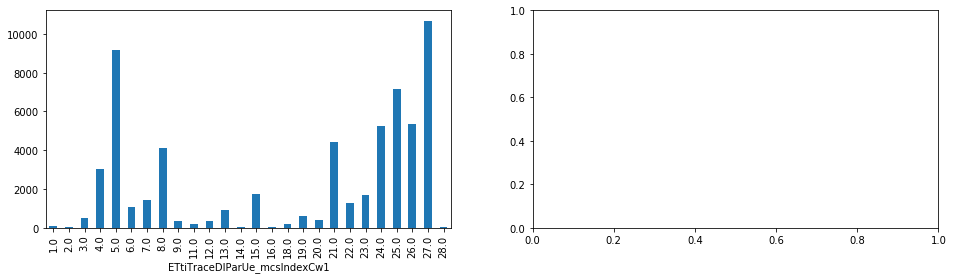

CW1/CW2 ACK/NACK/DTX Distribution:


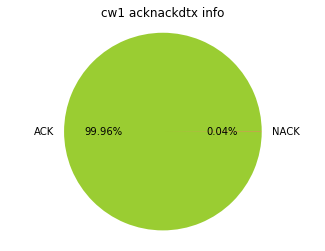

DRB Number Distribution:


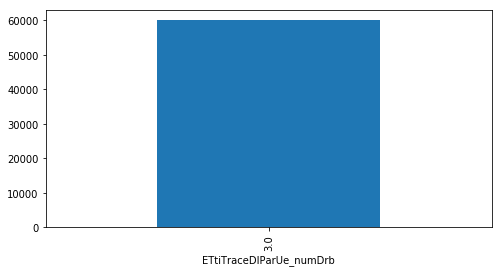

DRB Buffer VS Time:


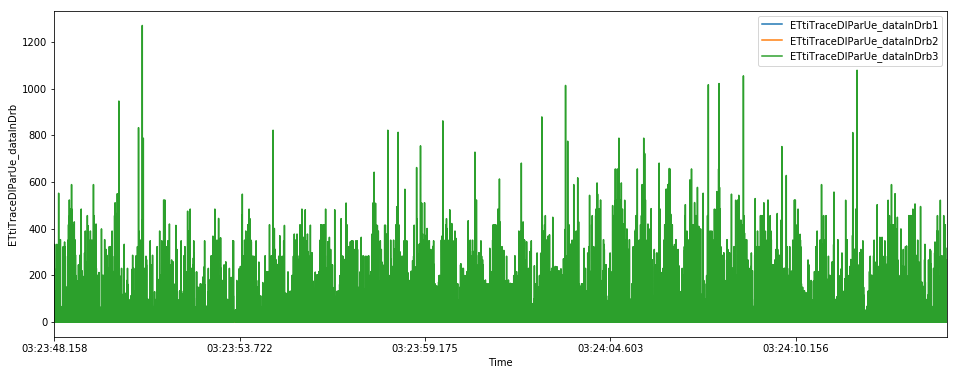

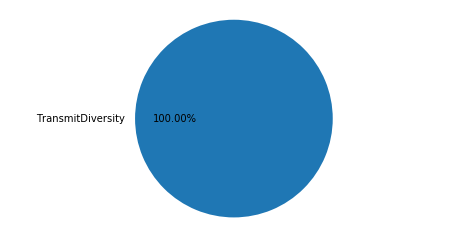

In [3]:
# 可视化

# dl subframe UE per tti数目的分布
print('FD number VS Subframe number:')
fig = plt.figure(figsize=(8,4))
dl_esfn_vs_fd = ttitrace_dl.groupby('ETtiTraceDlParCell_esfn')['ETtiTraceDlParCell_numUesFd'].mean()
ax = dl_esfn_vs_fd.plot(kind='bar')
ax.set_xlabel('ETtiTraceDlParCell_esfn')
ax.set_ylabel('ETtiTraceDlParCell_numUesFd')
plt.show()

# cw1和cw2 mcs的分布
print('CW1/CW2 MCS Index Distribution:')
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
# ax1 = ttitrace_dl['ETtiTraceDlParUe_mcsIndexCw1'].value_counts().plot(kind='bar')
ax1 = ttitrace_dl.groupby('ETtiTraceDlParUe_mcsIndexCw1').size().plot(kind='bar')
ax2 = fig.add_subplot(122)
# ax2 = ttitrace_dl['ETtiTraceDlParUe_mcsIndexCw2'].value_counts().plot(kind='bar')
# ax2 = ttitrace_dl.groupby('ETtiTraceDlParUe_mcsIndexCw2').size().plot(kind='bar')
plt.show()

# cw1和cw2 ACK/NACK/DTX的百分比
print('CW1/CW2 ACK/NACK/DTX Distribution:')
fig = plt.figure(figsize=(12,4))
colors = ['yellowgreen', 'red', 'lightskyblue', 'grey']
ax1 = fig.add_subplot(121)
ax1 = ttitrace_dl['EHarqParDl_ackNackDtxCw1'].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=colors)
ax1.axis('equal')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('cw1 acknackdtx info')
# ax2 = fig.add_subplot(122)
# ax2 = ttitrace_dl['EHarqParDl_ackNackDtxCw2'].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=colors)
# ax2.axis('equal')
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.set_title('cw2 acknackdtx info')
plt.show()

# DRB数量分布
print('DRB Number Distribution:')
fig = plt.figure(figsize=(8,4))
ax = ttitrace_dl.groupby('ETtiTraceDlParUe_numDrb').size().plot(kind='bar')
plt.show()

# DRB Buffer中数据分布
print('DRB Buffer VS Time:')

dl_drb_vs_time = ttitrace_dl.groupby('Time')[['ETtiTraceDlParUe_dataInDrb1','ETtiTraceDlParUe_dataInDrb2',
                                              'ETtiTraceDlParUe_dataInDrb3']].sum()
ax = dl_drb_vs_time.plot(kind='line', figsize=(16,6))
ax.set_xlabel('Time')
ax.set_ylabel('ETtiTraceDlParUe_dataInDrb')
plt.show()

# 调制解调方式分布
fig = plt.figure(figsize=(8,4))
ax = ttitrace_dl['ETtiTraceDlParUe_transmMode'].value_counts().plot(kind='pie', autopct='%1.2f%%')
ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### Analyze UL ttitrace

In [4]:
print('Start to analyze UL ttitrace...')

# 读取数据并整理
ttitrace_ul = load_tti_data(TTITRACE_PATH, FILENAME_UL)
ttitrace_ul = ttitrace_ul.iloc[:,:-1]
ttitrace_ul.dropna(subset=["ETtiTraceUlParUe_cRnti", "ETtiTraceUlParCell_esfn"], axis=0, inplace=True)
ttitrace_ul.reset_index(inplace=True)
ttitrace_ul['Time'] = [pd.datetime.strftime(pd.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S.%fZ'), '%H:%M:%S.%f')[:-3]
                       for s in ttitrace_ul['Time']]

# 打印dataframe基本信息
ttitrace_ul.info()

Start to analyze UL ttitrace...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57320 entries, 0 to 57319
Columns: 197 entries, index to EHarqParUl_CoMP
dtypes: bool(1), float64(85), int64(99), object(12)
memory usage: 85.8+ MB


In [5]:
# 抽取Cell ID，PRB数目
# ttitrace中每个tti对应多个UE的调度，在统计某些参数时候需要对统一时间戳的数值求和，比如单tti调度的prb数目prb_used
cell_id = ttitrace_ul['ETtiTraceUlParCell_cellId'][0]
prb_available = ttitrace_ul.groupby('Time')['ETtiTraceUlParCell_totalPrbAvail'].mean()
prb_available_mean = prb_available.mean()
prb_used = ttitrace_ul.groupby('Time')['ETtiTraceUlParUe_numberOfPrsAlloc'].sum()
prb_used_mean = prb_used.mean()
print('cell id:', int(cell_id))
print('available prb number: {:.1f}'.format(prb_available_mean))
print('prb allocated: {:.1f}'.format(prb_used_mean))

# 统计fd（ul subframe UE per tti）
ul_fd_num = ttitrace_ul['ETtiTraceUlParCell_numUesFd'].mean()
print('ul mean FD number: {:.2f}'.format(ul_fd_num))

# 统计PUCCH/PUSCH rssi/sinr
ul_pusch_rssi_mean = ttitrace_ul['EHarqParUl_rssiPusch'].mean()
ul_pucch_rssi_mean = ttitrace_ul['ETtiTraceUlParUe_rssiPucch'].mean()
ul_pusch_sinr_mean = ttitrace_ul['EHarqParUl_sinrPusch'].mean()
ul_pucch_sinr_mean = ttitrace_ul['ETtiTraceUlParUe_sinrPucch'].mean()
print('ul pusch rssi mean: {:.2f}dBm'.format(ul_pusch_rssi_mean))
print('ul pucch rssi mean: {:.2f}dBm'.format(ul_pucch_rssi_mean))
print('ul pusch sinr mean: {:.2f}dB'.format(ul_pusch_sinr_mean))
print('ul pucch sinr mean: {:.2f}dB'.format(ul_pucch_sinr_mean))

# 分别对单tti和总测试时间段统计ul mcs
ul_mcs_index_cw1 = ttitrace_ul['ETtiTraceUlParUe_mcsIndexCw1']
ul_mcs_index_cw1_mean = ul_mcs_index_cw1.mean()
print('ul mean mcs for cw1: {:.2f}'.format(ul_mcs_index_cw1_mean))

# 分别对单tti和总测试时间段统计ul tb size
ul_tbs_cw1 = ttitrace_ul.groupby('Time')['ETtiTraceUlParUe_tbsCw1'].sum()
print('ul mean tbs for cw1: {:.2f}'.format(ul_tbs_cw1.mean()))

# 统计ul ack ratio，dl harq状态包括ack，ack，dtx
ul_ack_cw1_group = ttitrace_ul.groupby('EHarqParUl_ackNackDtxCw1')
ul_ack_cw1 = ul_ack_cw1_group.size()['ACK']/ul_ack_cw1_group.size().sum()
print('ul harq ACK ratio for cw1: {:.2f}%'.format(ul_ack_cw1*100))

# 统计DRB数目
dl_drb_count = ttitrace_dl['ETtiTraceDlParUe_numDrb'].mean()
print('drb number is: {:.1f}'.format(dl_drb_count))

cell id: 43841
available prb number: 12.4
prb allocated: 12.4
ul mean FD number: 2.30
ul pusch rssi mean: -98.99dBm
ul pucch rssi mean: -113.70dBm
ul pusch sinr mean: 19.05dB
ul pucch sinr mean: 2.09dB
ul mean mcs for cw1: 23.96
ul mean tbs for cw1: 826.57
ul harq ACK ratio for cw1: 99.91%
drb number is: 3.0


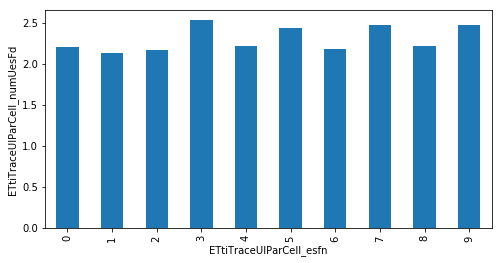

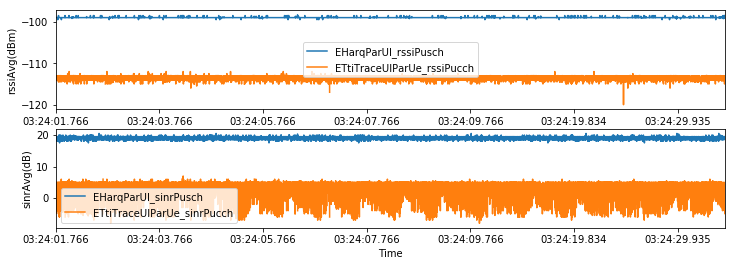

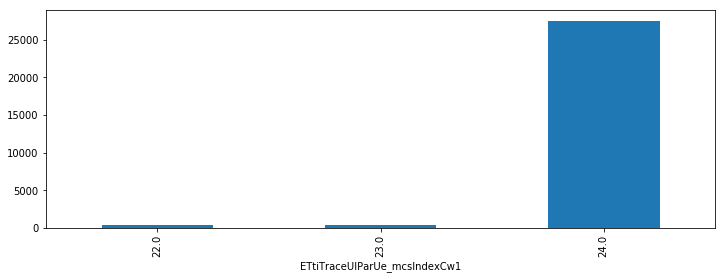

DRB Number Distribution:


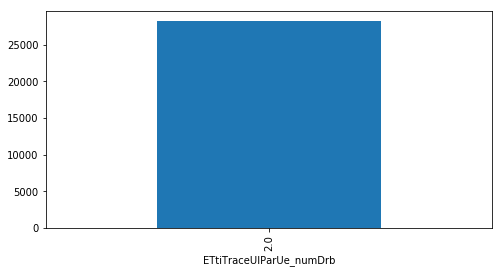

In [6]:
# 可视化

# ul subframe UE per tti数目的分布
fig = plt.figure(figsize=(8,4))
ul_esfn_vs_fd = ttitrace_ul.groupby('ETtiTraceUlParCell_esfn')['ETtiTraceUlParCell_numUesFd'].mean()
ax = ul_esfn_vs_fd.plot(kind='bar')
ax.set_xlabel('ETtiTraceUlParCell_esfn')
ax.set_ylabel('ETtiTraceUlParCell_numUesFd')
plt.show()

# ul rssi/sinr分布
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(211)
ul_rssi_vs_time = ttitrace_ul.groupby('Time')[['EHarqParUl_rssiPusch','ETtiTraceUlParUe_rssiPucch']].mean()
ul_rssi_vs_time.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_ylabel('rssiAvg(dBm)')

ax2 = fig.add_subplot(212)
ul_sinr_vs_time = ttitrace_ul.groupby('Time')[['EHarqParUl_sinrPusch','ETtiTraceUlParUe_sinrPucch']].mean()
ul_sinr_vs_time.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_ylabel('sinrAvg(dB)')
plt.show()

# cw1 mcs的分布
fig = plt.figure(figsize=(12,4))
ax = ttitrace_ul.groupby('ETtiTraceUlParUe_mcsIndexCw1').size().plot(kind='bar')
plt.show()

# DRB数量分布
print('DRB Number Distribution:')
fig = plt.figure(figsize=(8,4))
ax = ttitrace_ul.groupby('ETtiTraceUlParUe_numDrb').size().plot(kind='bar')
plt.show()